# Model Building and Fine-Tuning with GenAI

- **Explore** a baseline fraud detection dataset.
- **Generate advanced features** using GenAI suggestions (e.g., transaction patterns, rolling statistics).
- **Build a baseline classification model** using TensorFlow.
- **Enhance the model** using GenAI-augmented features, transfer learning with a pre-trained foundation model, and synthetic data generated via diffusion models.
- **Compare performance** between traditional and GenAI-enhanced models.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Only for correlation heatmap if needed (feel free to skip if you prefer matplotlib)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set matplotlib style (optional)
plt.style.use('default')


Dataset Shape: (10000, 21)
is_fraud
0    9462
1     538
Name: count, dtype: int64


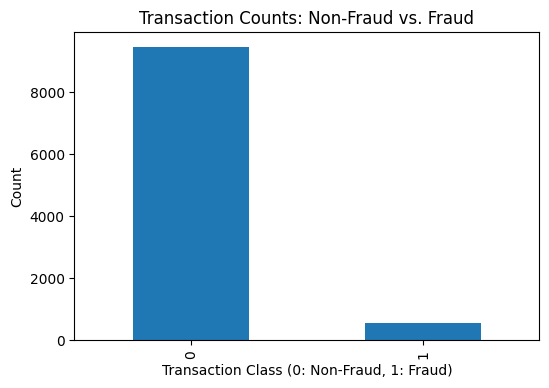

In [2]:
# Generate a synthetic fraud detection dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_redundant=5,
                           n_classes=2, weights=[0.95, 0.05], flip_y=0.01, random_state=42)

# Create a DataFrame for convenience
feature_names = [f"feature_{i}" for i in range(20)]
df = pd.DataFrame(X, columns=feature_names)
df['is_fraud'] = y

# Display basic statistics
print("Dataset Shape:", df.shape)
print(df['is_fraud'].value_counts())

# Quick visualization: Fraud vs. Non-Fraud counts
plt.figure(figsize=(6,4))
df['is_fraud'].value_counts().plot(kind='bar')
plt.title('Transaction Counts: Non-Fraud vs. Fraud')
plt.xlabel('Transaction Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()


## Exploratory Data Analysis

- The dataset is highly imbalanced (as expected in fraud detection).
- We can further inspect feature distributions and correlations to understand our data better.


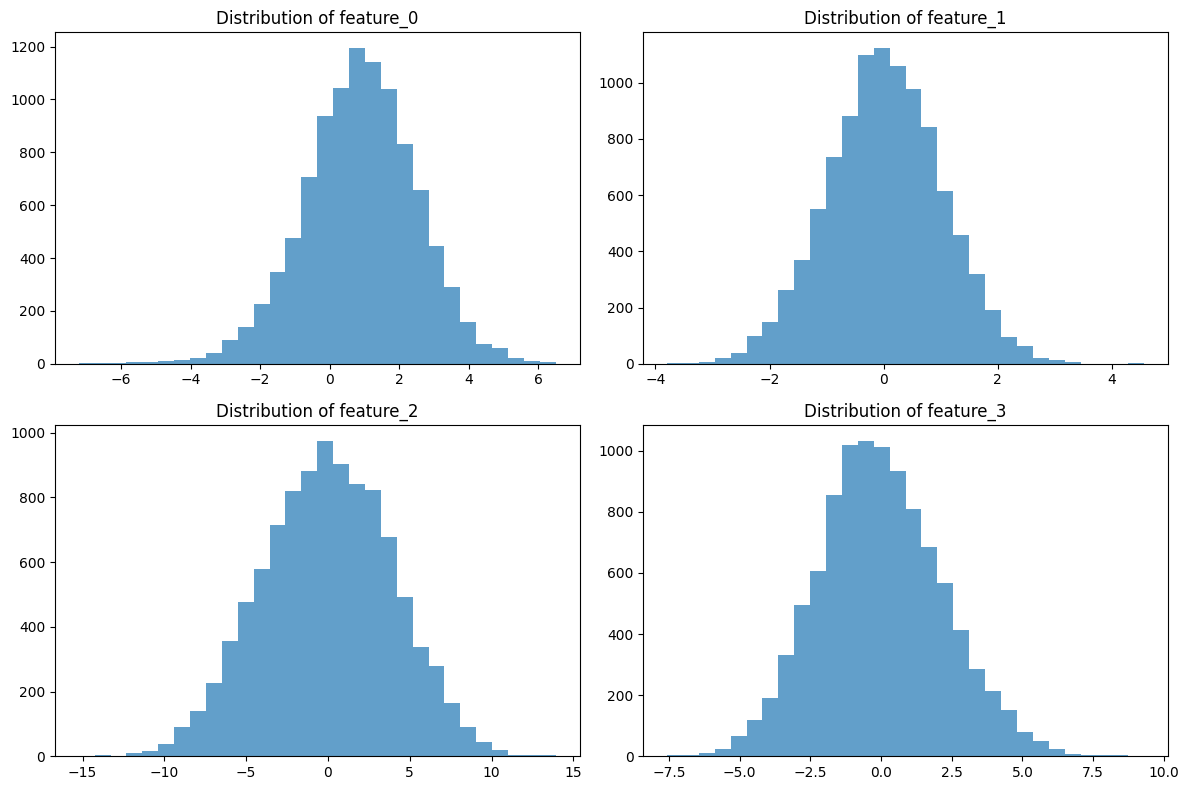

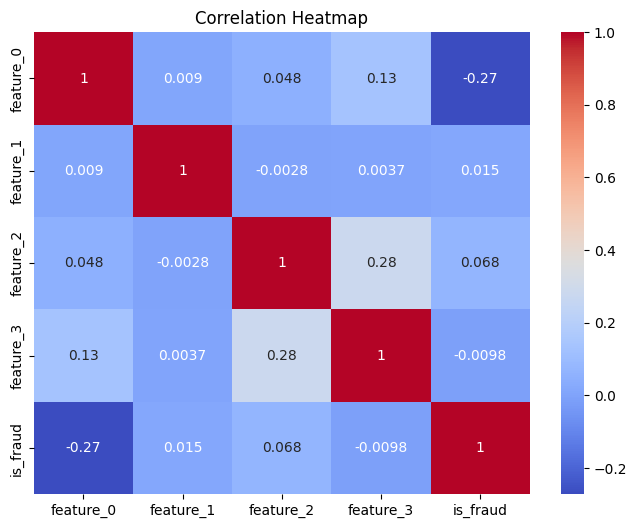

In [3]:
# Plot distributions for a few selected features
selected_features = feature_names[:4]
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 2, i+1)
    plt.hist(df[feature], bins=30, alpha=0.7)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap for a subset of features
plt.figure(figsize=(8, 6))
subset = df[selected_features + ['is_fraud']]
sns.heatmap(subset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## Baseline Model Building

We first build a simple classification model using TensorFlow/Keras with the original features.


In [6]:
# Split data into training and testing sets (80-20 split)
X = df[feature_names]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the baseline model
baseline_model = create_model(X_train.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_base = baseline_model.fit(X_train, y_train,
                                  validation_split=0.2,
                                  epochs=20,
                                  batch_size=64,
                                  callbacks=[early_stop],
                                  verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9045 - loss: 0.2795 - val_accuracy: 0.9575 - val_loss: 0.1344
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9544 - loss: 0.1694 - val_accuracy: 0.9663 - val_loss: 0.1156
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9554 - loss: 0.1499 - val_accuracy: 0.9656 - val_loss: 0.1099
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9642 - loss: 0.1395 - val_accuracy: 0.9675 - val_loss: 0.1053
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9645 - loss: 0.1356 - val_accuracy: 0.9700 - val_loss: 0.1019
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1348 - val_accuracy: 0.9712 - val_loss: 0.0982
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9689 - loss: 0.1227 - val_accuracy: 0.9712 - val_loss: 0.0959
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.1247 - val_accuracy: 0.

Baseline Model Accuracy: 0.9750
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


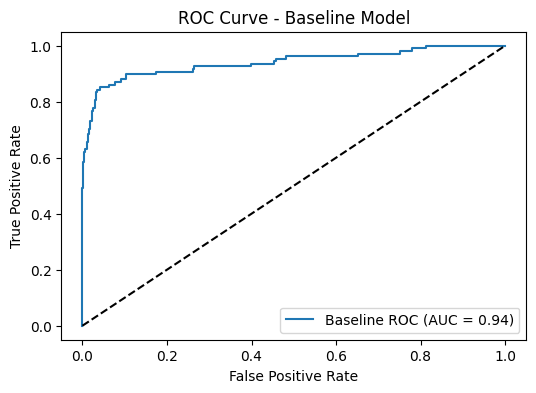

In [8]:
# Evaluate on test set
loss_base, acc_base = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"Baseline Model Accuracy: {acc_base:.4f}")

# ROC Curve for Baseline Model
y_pred_base = baseline_model.predict(X_test).ravel()
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_base)
roc_auc_base = auc(fpr_base, tpr_base)

plt.figure(figsize=(6, 4))
plt.plot(fpr_base, tpr_base, label=f'Baseline ROC (AUC = {roc_auc_base:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Baseline Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [16]:
# prompt: print a classification report for the above model

y_pred_classes = (baseline_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1892
           1       0.93      0.58      0.72       108

    accuracy                           0.97      2000
   macro avg       0.95      0.79      0.85      2000
weighted avg       0.97      0.97      0.97      2000



## GenAI-Enhanced Model

**Synthetic Data Generation:** We use CTGAN to augment the dataset and will then train another model on this enhanced data.


In [9]:
!pip install ctgan

In [10]:
from ctgan import CTGAN

In [11]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a synthetic fraud detection dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_redundant=5,
                           n_classes=2, weights=[0.95, 0.05], flip_y=0.01, random_state=42)

# Create DataFrame
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(20)])
df['is_fraud'] = y

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['is_fraud'], random_state=42)

In [41]:
# Train CTGAN on the minority class
ctgan = CTGAN(epochs=500, batch_size=500)
fraud_only = train_df[train_df['is_fraud'] == 1]
ctgan.fit(fraud_only, discrete_columns=['is_fraud'])

# Generate synthetic fraud transactions
num_synthetic = len(fraud_only)
synth_fraud = ctgan.sample(num_synthetic)

# Merge synthetic fraud with real training data
augmented_train_df = pd.concat([train_df, synth_fraud], ignore_index=True)

# Prepare datasets for training
X_train = augmented_train_df.drop(columns=['is_fraud'])
y_train = augmented_train_df['is_fraud']
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

In [42]:
# Define a simple fraud detection model
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train model on augmented data
model = create_model(X_train.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=64, callbacks=[early_stop], verbose=1)

# Evaluate model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Augmented Model Accuracy: {acc:.4f}")

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9118 - loss: 0.2634 - val_accuracy: 0.7183 - val_loss: 1.0834
Epoch 2/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9562 - loss: 0.1562 - val_accuracy: 0.7408 - val_loss: 1.0683
Epoch 3/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9628 - loss: 0.1411 - val_accuracy: 0.7622 - val_loss: 0.9738
Epoch 4/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9632 - loss: 0.1299 - val_accuracy: 0.7728 - val_loss: 0.9195
Epoch 5/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9654 - loss: 0.1226 - val_accuracy: 0.7811 - val_loss: 0.8739
Epoch 6/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9669 - loss: 0.1158 - val_accuracy: 0.7977 - val_loss: 0.8098
Epoch 7/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9674 - loss: 0.1102 - val_accuracy: 0.8043 - val_loss: 0.8169
Epoch 8/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.1120 - val_accuracy:

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


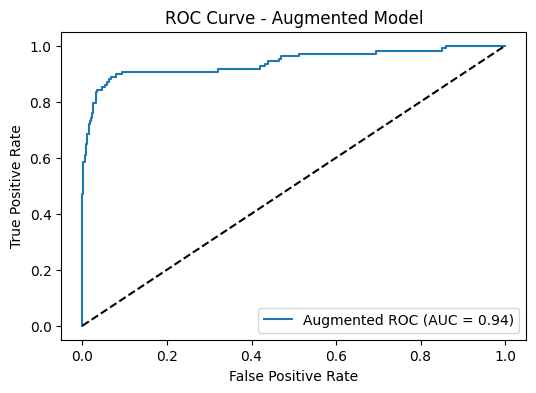

In [43]:
# ROC Curve
y_pred = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Augmented ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Augmented Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [44]:
# Print classification report
print(classification_report(y_test, (y_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1892
           1       0.91      0.58      0.71       108

    accuracy                           0.97      2000
   macro avg       0.94      0.79      0.85      2000
weighted avg       0.97      0.97      0.97      2000



## Performance Comparison

Let's compare the key performance metrics (Accuracy and AUC) between the baseline and the GenAI-enhanced models.


Baseline Model Accuracy: 0.9750, AUC: 0.9400
Augmented Model Accuracy: 0.9745, AUC: 0.9403


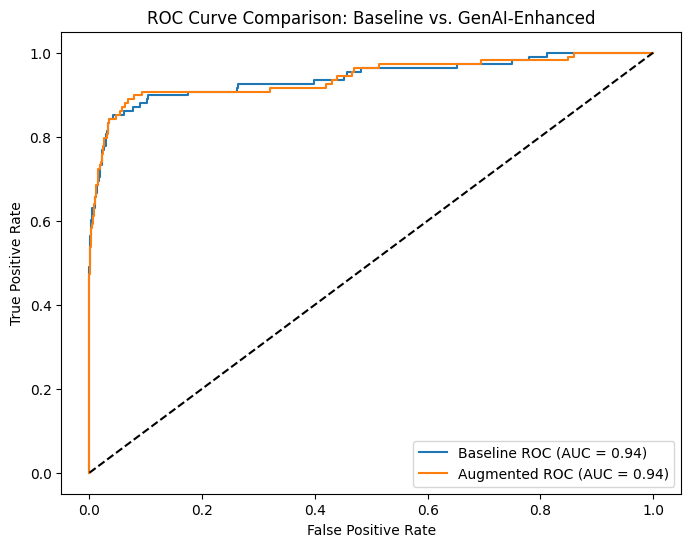

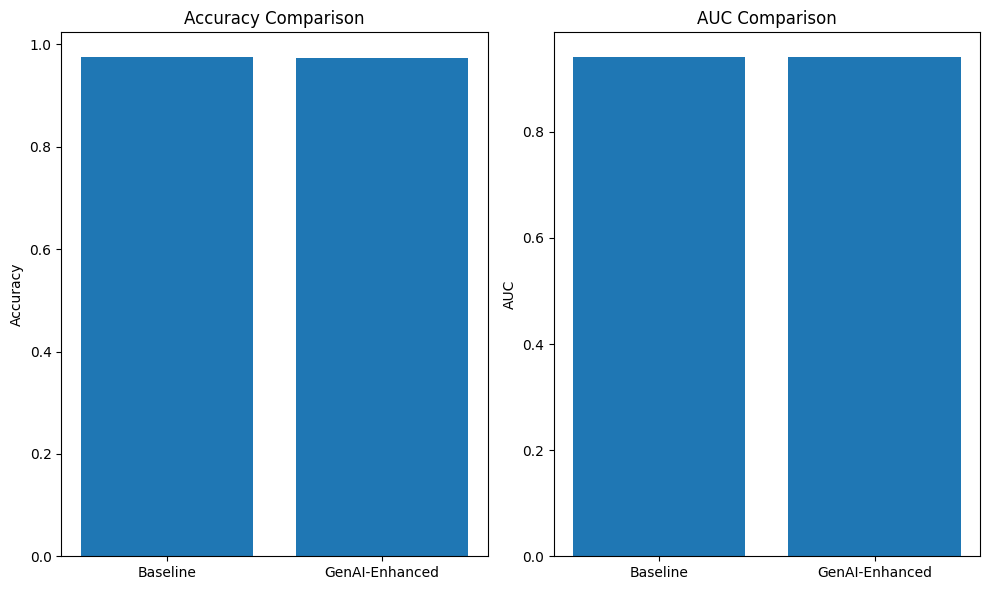

In [45]:
# prompt: create a comparison (numerical and graphical) between the two above models

# Comparison of Performance Metrics
print(f"Baseline Model Accuracy: {acc_base:.4f}, AUC: {roc_auc_base:.4f}")
print(f"Augmented Model Accuracy: {acc:.4f}, AUC: {roc_auc:.4f}")

# Graphical Comparison (ROC Curve)
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline ROC (AUC = {roc_auc_base:.2f})')
plt.plot(fpr, tpr, label=f'Augmented ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison: Baseline vs. GenAI-Enhanced')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# You can also create a bar chart comparing accuracy and AUC scores visually.

# Example:
metrics_df = pd.DataFrame({
    'Model': ['Baseline', 'GenAI-Enhanced'],
    'Accuracy': [acc_base, acc],
    'AUC': [roc_auc_base, roc_auc]
})

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(metrics_df['Model'], metrics_df['Accuracy'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(metrics_df['Model'], metrics_df['AUC'])
plt.title('AUC Comparison')
plt.ylabel('AUC')

plt.tight_layout()
plt.show()


# Conclusion

In this notebook, we:
- Explored a synthetic fraud detection dataset.
- Built a baseline model using original features.
- Enhanced the model with synthetic data generation.
- Compared the performance of both models.

Feel free to experiment further after the class: Do some feature engineering (see notebook number 1 for examples), add more visuals, and refine the models based on your dataset or domain-specific needs.
